#### For volcano plot (pre vs. post tratment in drug resistant sarcoma patients) in Figure 5

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import colors
import os
from numpy import ma
import seaborn as sns
%matplotlib inline
from scipy import stats
from scipy.stats import zscore
from sklearn.decomposition import PCA
from natsort import natsorted
import ipywidgets
from glob import glob
import logging
import sys
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind
from statistics import mean
from scipy.stats import t

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure4 data_SenstiveResistant')

In [ ]:
# ProteinQuantitationWithSampleMetadata.xlsx is on the SarcomaEV github page

dfSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/ProteinQuantitationWithSampleMetadata.xlsx', sheet_name='Sheet1')

In [4]:
parser = 'group'

In [ ]:
# Filter for the analysis

df = dfSarcoma
dataTypeFilter = 'NormalizedIntensity_Log2'
    
df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("dataType == @dataTypeFilter")

df = df.query("timing != 'Control' and sensitivity == 'R'") # resitant

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column specifying the dataset
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfProtein = df

#### annotate merged long/tidy data with uniprot IDs (or other metadata)

In [ ]:
# make dfUniprot for annotation, uniprotAnnotationsForFigure2.xlsx is on the SarcomaEV GitHub page

dfUniprot = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/uniprotAnnotationsForFigure2.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)

In [24]:
# annotate uniprot info
dfMerged = dfProtein.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfMerged.columns
numCols = dfMerged._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfMerged['area'] = dfMerged['area'].astype(float)

In [25]:
# remove Remove 'crapome' proteins

crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']

dfMerged = dfMerged.loc[~dfMerged['geneNamePrimary'].str.contains('|'.join(crapome))]

In [26]:
# count protein IDs

dfTemp = dfMerged

nSamplesFilter = 10
nSamplesControlOnlyFilter = 0
    
#drop 0 values
dfTemp.dropna(subset = ['area'], inplace = True)

# count
dfTemp['nSamples'] = dfTemp.groupby('protAcc')['protAcc'].transform('count')
nSamplesControlOnly = dfTemp.query('cancer == "n"').groupby('protAcc')['protAcc'].agg('count').to_frame()
nSamplesControlOnly.rename(columns = {'protAcc' : 'nSamplesControlOnly'}, inplace = True)
dfTemp = dfTemp.join(nSamplesControlOnly, on = 'protAcc')
dfTemp['nSamplesControlOnly'] = dfTemp['nSamplesControlOnly'].fillna(0)

# filter by N detections
dfTemp = dfTemp.query('nSamples >= @nSamplesFilter')
dfTemp = dfTemp.query('nSamplesControlOnly >= @nSamplesControlOnlyFilter')

dfFiltered = dfTemp

In [27]:
# find and select data/feature columns

totalCols = dfFiltered.columns
numCols = dfFiltered._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

# pivot 
dfStatsPre = dfFiltered.pivot_table(
    values = 'area',
    index = [parser,'sample'],
    columns = ['geneNamePrimary'],
).reset_index().rename_axis(None, axis=1)
dfStatsPre.set_index(parser, inplace = True)

dfStatsPre.reset_index(inplace = True)
sampleNames = dfStatsPre['sample']
dfStatsPre = dfStatsPre.drop(columns = ['sample'])

# impute nan to min value in column

for col in dfStatsPre.columns:
    dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_55675/3059717704.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)


In [28]:
# melt
dfStatsPre = dfStatsPre.melt(
    id_vars = parser,
    value_name = 'area',
    var_name = 'geneNamePrimary',
)

In [29]:
# setup groups

RPre = dfStatsPre.query('group == "R.Post"')
SPre = dfStatsPre.query('group == "R.Pre"')

In [ ]:
# make dfStats with pvals / qvals and other stats

colName = 'geneNamePrimary'
valueCol = 'area'

# make a list of all genes
allGenes = dfStatsPre['geneNamePrimary'].unique()

# to make new dfStats
dfStats = pd.DataFrame()
geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalPingouinList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = RPre.query("{0} == '{1}'".format(colName, i))
    group2 = SPre.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)

    group1List.append(group1)
    group2List.append(group2)
    
    if len(group1) < 2 or len(group2) < 2:
        if len(group1) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        elif len(group2) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        continue
    else:
        oneGroupDetectionList.append('')
        
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False)
        pvalScipyList.append(p)
        display(p)

dfStats['geneNamePrimary'] = geneNamePrimaryList
dfStats['RPre'] = group1List
dfStats['SPre'] = group2List
dfStats['meanRPre']= group1MeanList
dfStats['meanSPre']= group2MeanList
dfStats['oneGroupDetection'] = oneGroupDetectionList
dfStats['pvalScipy'] = pvalScipyList

# define direction change
dfStats['directionChange'] = np.where((dfStats['meanRPre'] > dfStats['meanSPre']), 'up', 'down')
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChange'])
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChange'])

In [31]:
# drop missing values
dfStats.dropna(subset=['pvalScipy'], inplace = True)

### BH FDR correction

In [32]:
# Benjmani-hochburg correction
from statsmodels.stats.multitest import multipletests

# BH FDR correction with stats models
scipyQvals = multipletests(dfStats.query("pvalScipy != ''")['pvalScipy'], alpha=0.05, method="fdr_bh")

# rename column
dfStats.loc[dfStats['pvalScipy'] != '', 'qvalScipy'] = scipyQvals[1]

In [33]:
# select significant proteins (FDR)

dfStats['sigFDR'] = 'notSig'
dfStats.loc[pd.isnull(dfStats['qvalScipy']), 'sigFDR'] = 'sig'
dfStats.loc[dfStats['qvalScipy'] < 0.05, 'sigFDR'] = 'sig'

# list of all significant genes
geneNamePrimarySigAll = dfStats.query('sigFDR == "sig"')['geneNamePrimary'].tolist()

In [ ]:
# some calulations needed for the volcano plot

# calc ratios
dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] / dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = np.log2(dfStats['FC_RPre:SPre'])

dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] - dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = dfStats['FC_RPre:SPre']

# -log10 q values
dfStats['-log10qvalScipy'] = np.log10(dfStats['qvalScipy']).mul(-1)
dfStats['-log10qvalScipyRank'] = dfStats['-log10qvalScipy'].rank(method = 'first', ascending = False)

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1437: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1439: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:692: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:693: FutureWarning: Calling float on a single element Series is deprecated and will r

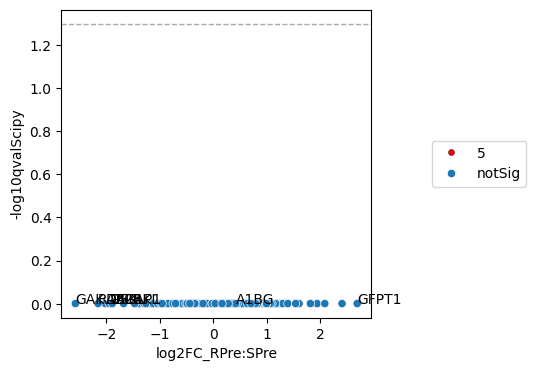

In [35]:
# make annotated volcano plot

diffExprGeneList = dfStats[dfStats['-log10qvalScipyRank'] < 1.301]['geneNamePrimary'].to_list()
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -1.5]['geneNamePrimary'].to_list())
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 2.5]['geneNamePrimary'].to_list())

mask = dfStats['geneNamePrimary'].isin(diffExprGeneList)
annotations = diffExprGeneList

diffExprGeneListAlt = dfStats[dfStats['-log10qvalScipyRank'] < 15]['geneNamePrimary'].to_list()
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -5]['geneNamePrimary'].to_list())
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 5]['geneNamePrimary'].to_list())

if len(diffExprGeneList) > 40:
    mask = dfStats['geneNamePrimary'].isin(diffExprGeneListAlt)
    annotations = diffExprGeneListAlt

plt.figure(figsize=(4,4))

sns.scatterplot(data = dfStats.loc[mask],
    x = 'log2FC_RPre:SPre',
    y = '-log10qvalScipy',
    size=5,
    facecolor = 'red',
    edgecolor = 'black',)

for i in annotations:
    plt.annotate(i,
        (dfStats[dfStats.geneNamePrimary == i]['log2FC_RPre:SPre'],
        dfStats[dfStats.geneNamePrimary == i]['-log10qvalScipy'],
        )
    ) 

sns.scatterplot(
    data=dfStats,
    x="log2FC_RPre:SPre",
    y="-log10qvalScipy",
    hue = 'sigFDR',
    ).axhline(
    1.3, color = 'darkgrey', linestyle = '--', linewidth=1)

plt.legend(bbox_to_anchor=(1.5, .5), loc='center right', borderaxespad=0)

plt.show()